In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random

In [2]:
model = interpretability.load_model(
    "../scripts/models/tiny model prob all games-20230811-173207"
)

In [3]:
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 6, 7, 8]])
seq_fwd.shape

torch.Size([1, 10])

In [4]:
pos_emb = model.pos_embed(seq_fwd, 0)
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
preds_mlp_pos = torch.softmax(logits_mlp_pos, axis=-1)
print(pos_emb.shape)
logits_mlp_pos.shape, preds_mlp_pos.shape

torch.Size([1, 10, 4])


(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]))

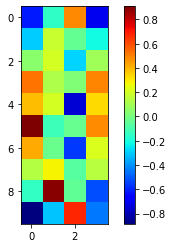

In [5]:
plt.imshow(pos_emb[0].detach().cpu().numpy(), cmap="jet")
plt.colorbar()

In [6]:
pos_emb[0]

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


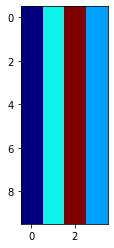

In [7]:
injected_pos = pos_emb[:, -1, :].expand(1, 10, 4)
plt.imshow(injected_pos[0].detach().cpu().numpy(), cmap="jet")
print(pos_emb[0])

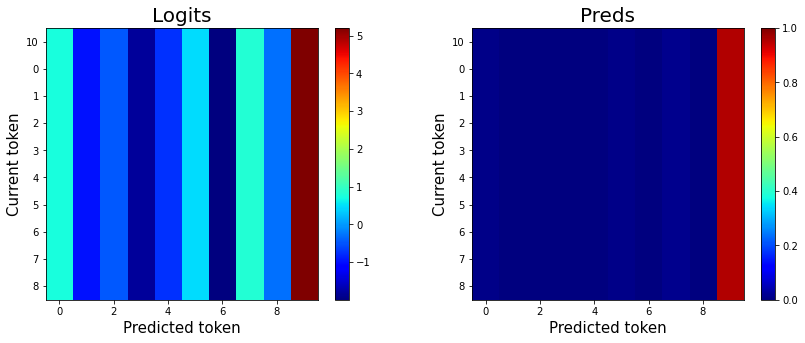

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [8]:
logits_injected = model.blocks[0].mlp(injected_pos) @ model.W_U
interpretability.plot_predictions(seq_fwd[0].tolist(), logits_injected)
print(pos_emb[0])

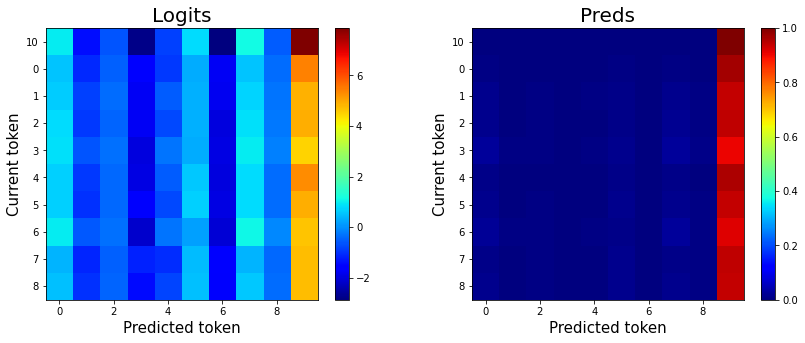

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [9]:
content_emb = model.embed(seq_fwd)
embeddings = content_emb + injected_pos
logits_emb = model.blocks[0].mlp(embeddings) @ model.W_U
interpretability.plot_predictions(seq_fwd[0].tolist(), logits_emb)
print(pos_emb[0])

In [10]:
def inject_posemb(seq, injected_pos_emb):
    def pos_hook(module, input, output):
        return injected_pos_emb
    try:
        pos_handle = model.hook_pos_embed.register_forward_hook(pos_hook)
        logits = model(seq)
        pos_handle.remove()
    except Exception as e:
        pos_handle.remove()
        raise e
    return logits

def inject_posemb_and_ablate_mlp(seq, injected_pos_emb):
    def pos_hook(module, input, output):
        return injected_pos_emb
    def zero_mlp_hook(module, input, output):
        return torch.zeros_like(output)
    
    try:
        pos_handle = model.hook_pos_embed.register_forward_hook(pos_hook)
        mlp_handle = model.blocks[0].mlp.hook_post.register_forward_hook(zero_mlp_hook)
        logits = model(seq)
        pos_handle.remove()
        mlp_handle.remove()
    except Exception as e:
        pos_handle.remove()
        mlp_handle.remove()
        raise e
    return logits
print(pos_emb[0])

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [11]:
injected_logits = inject_posemb(seq_fwd[0], injected_pos)
print(pos_emb[0])

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


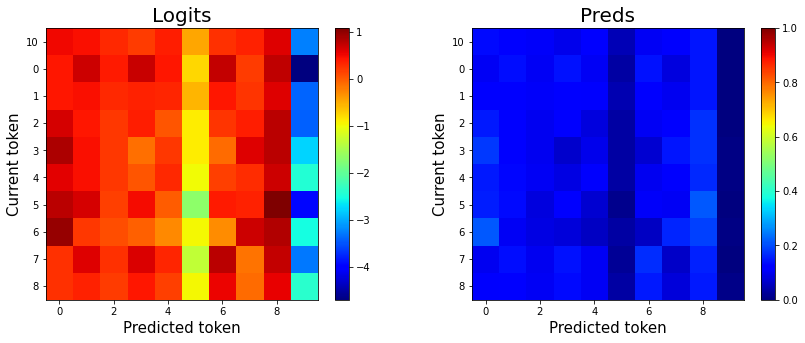

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [12]:
interpretability.plot_predictions(seq_fwd[0].tolist(), injected_logits)
print(pos_emb[0])

In [13]:
injected_ablated_logits = inject_posemb_and_ablate_mlp(seq_fwd[0], injected_pos)
print(pos_emb[0])

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


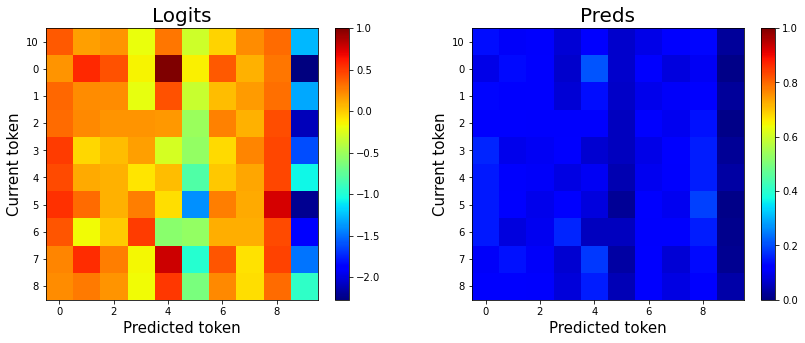

tensor([[-0.6159, -0.1526,  0.4808, -0.7040],
        [-0.3000,  0.1748, -0.0408, -0.2143],
        [ 0.0429,  0.2052, -0.2838,  0.0945],
        [ 0.5256,  0.1234,  0.0243,  0.4900],
        [ 0.3849,  0.2006, -0.7469,  0.3322],
        [ 0.9074, -0.1229, -0.0354,  0.4743],
        [ 0.4210, -0.0262, -0.5573,  0.2214],
        [ 0.1314,  0.2797, -0.0692,  0.1443],
        [-0.1466,  0.8933, -0.0453, -0.5246],
        [-0.8843, -0.3145,  0.6732, -0.4458]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [14]:
interpretability.plot_predictions(seq_fwd[0].tolist(), injected_ablated_logits)
print(pos_emb[0])

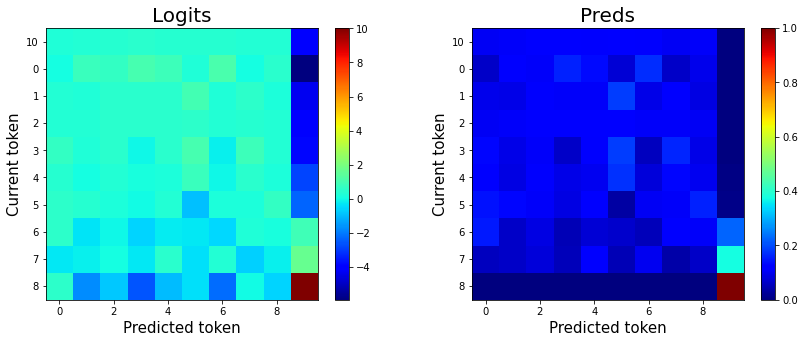

tensor([ 4.9660e-01, -1.7094e+00, -7.7598e-01, -2.6003e+00, -9.5432e-01,
        -4.4037e-01, -2.2416e+00, -2.1261e-03, -6.1384e-01,  1.0020e+01],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [33]:
interpretability.plot_predictions(seq_fwd[0].tolist(), model(seq_fwd[0]))
print(model(seq_fwd[0])[0, -1])

In [47]:
cool_preds = []
for pos in range(pos_emb.shape[1]):
    master_cool = pos_emb[:, -1, :].clone().expand(1, 10, 4).clone()
    master_cool[:, pos, :] = pos_emb[:, pos, :]
    cool_preds.append(torch.softmax(inject_posemb(seq_fwd[0], master_cool), axis=-1)[0,-1])

#stack
cool_preds = torch.stack(cool_preds, axis=0)
cool_preds

tensor([[0.1089, 0.1238, 0.1055, 0.1356, 0.1057, 0.0338, 0.1529, 0.0769, 0.1492,
         0.0075],
        [0.1110, 0.1198, 0.1052, 0.1329, 0.1042, 0.0327, 0.1537, 0.0750, 0.1508,
         0.0146],
        [0.1227, 0.0820, 0.0902, 0.0765, 0.0850, 0.0370, 0.0925, 0.0794, 0.1259,
         0.2087],
        [0.1143, 0.0689, 0.0789, 0.0617, 0.0733, 0.0339, 0.0749, 0.0733, 0.1106,
         0.3101],
        [0.0667, 0.0264, 0.0376, 0.0211, 0.0323, 0.0259, 0.0242, 0.0456, 0.0483,
         0.6718],
        [0.0064, 0.0015, 0.0026, 0.0010, 0.0020, 0.0018, 0.0012, 0.0039, 0.0037,
         0.9760],
        [0.1319, 0.0905, 0.0959, 0.0852, 0.0891, 0.0372, 0.1002, 0.0859, 0.1384,
         0.1457],
        [0.1284, 0.0981, 0.1023, 0.0952, 0.0984, 0.0412, 0.1130, 0.0860, 0.1403,
         0.0971],
        [0.1111, 0.1183, 0.1046, 0.1345, 0.1021, 0.0319, 0.1550, 0.0740, 0.1516,
         0.0167],
        [0.1126, 0.1232, 0.1051, 0.1340, 0.1035, 0.0333, 0.1490, 0.0790, 0.1521,
         0.0080]], device='c

Text(0, 0.5, 'Reinserted Positional Embedding')

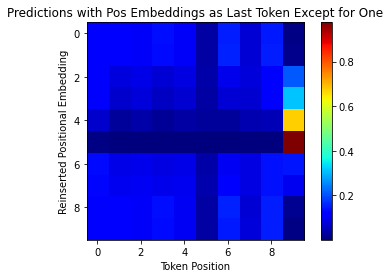

In [49]:
plt.imshow(cool_preds.detach().cpu().numpy(), cmap="jet")
plt.colorbar()
plt.title("Predictions with Pos Embeddings as Last Token Except for One")
plt.gcf().set_facecolor("white")
#x label
plt.xlabel("Token Position")
#y label
plt.ylabel("Reinserted Positional Embedding") 

In [16]:
second_to_last_logits = inject_posemb(seq_fwd[0], master_cool)

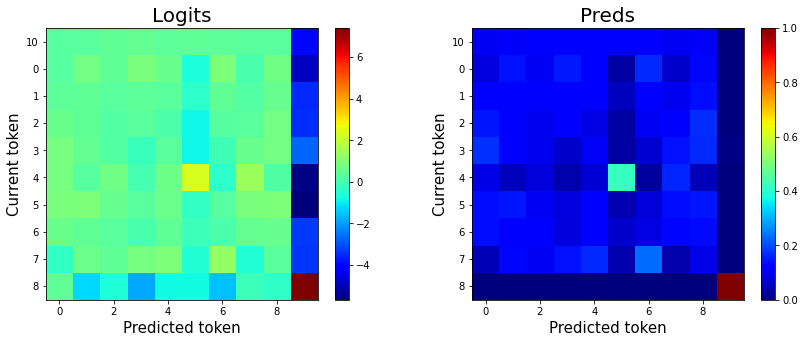

In [17]:
interpretability.plot_predictions(seq_fwd[0].tolist(), second_to_last_logits)

In [36]:
logits_true = model(seq_fwd[0])
logits_control = inject_posemb(seq_fwd[0], pos_emb)
#sum across all dimensions
print((logits_true-logits_control).sum())

tensor(0.7582, device='cuda:0', grad_fn=<SumBackward0>)


In [37]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [38]:
test = neuron_posembed_activations(pos_emb)
test.shape

torch.Size([1, 10, 16])

In [39]:
last_token_acts = test[0][-1].detach().cpu().numpy()

In [40]:
print(np.count_nonzero(last_token_acts))
print(np.count_nonzero(last_token_acts) / last_token_acts.size)

12
0.75


In [41]:
last_token_2d = last_token_acts[np.newaxis, :]
last_token_2d.shape

(1, 16)

Text(0.5, 0, 'Neuron')

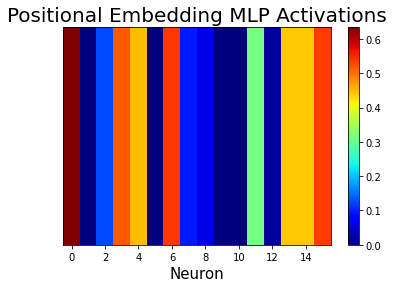

In [42]:
#plot last token acts imshow
plt.imshow(last_token_2d, aspect="auto", cmap="jet")
plt.colorbar()
#figsize params
plt.rcParams['figure.figsize'] = 10, 5
#title
plt.title("Positional Embedding MLP Activations", fontsize=20)
plt.gcf().set_facecolor("white")
#y tick
plt.yticks([1])
#x label
plt.xlabel("Neuron", fontsize=15)


In [43]:
games = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')
games.head()

/tmp/ipykernel_113408/1995611786.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [44]:
nine_move_games = [[10]+eval(move) for move in games[games['steps till end state'] == 9]['moves played']]

In [45]:
activations = []
for _ in range(500):
    data = torch.tensor(random.choice(nine_move_games))
    activations.append(neuron_activations(data)[0][-1])

In [46]:
stacked_acts = torch.stack(activations)
activation_counts = (stacked_acts != 0).sum(dim=0)
activation_frequency = activation_counts / stacked_acts.shape[0]
activation_frequency = activation_frequency.detach().cpu().numpy()
activation_frequency = activation_frequency[np.newaxis, :]

Text(0.5, 0, 'Neuron')

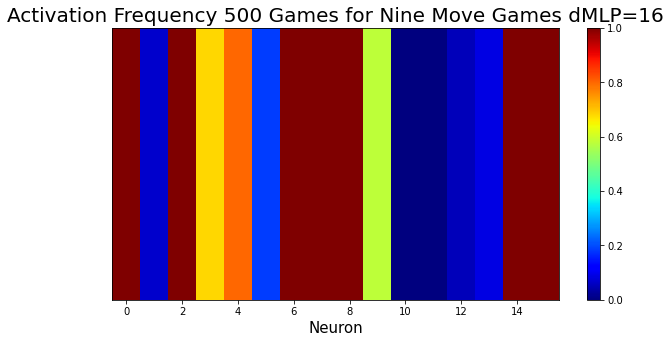

In [47]:
#plot last token acts imshow
plt.imshow(activation_frequency, aspect="auto", cmap="jet")
plt.colorbar()
#figsize params
plt.rcParams['figure.figsize'] = 12, 6
#title
plt.title("Activation Frequency 500 Games for Nine Move Games dMLP=16", fontsize=20)
plt.gcf().set_facecolor("white")
#y tick
plt.yticks([1])
#x label
plt.xlabel("Neuron", fontsize=15)

Text(0.5, 0, 'Neuron')

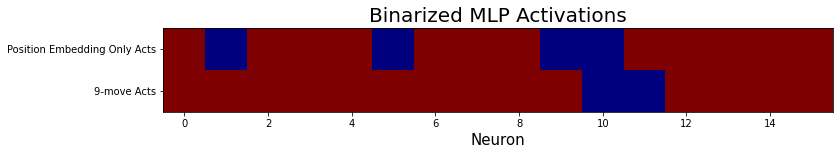

In [48]:
pos_acts = (last_token_2d[0] != 0)
acts_nine_move = (activation_frequency[0] != 0)
acts = [pos_acts, acts_nine_move]
#imshow booleans
plt.imshow(acts, cmap="jet")
#yticks
plt.yticks(np.arange(len(acts)), labels=["Position Embedding Only Acts", "9-move Acts"])
plt.gcf().set_facecolor("white")
#title
plt.title("Binarized MLP Activations", fontsize=20)
#xlabel
plt.xlabel("Neuron", fontsize=15)